In [1]:
casa = False

In [2]:
from importlib.resources import files

data_root = files("zjet_corrections") / "corrections" / "pu"
print(any(p.name == "puWeights.json.gz" for p in data_root.rglob("puWeights.json.gz")))


True


In [3]:
from zjet_corrections.corrections import debug_jec_weightset
debug_jec_weightset('2018', mode='AK8', is_data=False)

{'path': '/tmp/tmps7nmh7_h/Summer19UL18_V5_MC_L1FastJet_AK8PFPuppi.jec.txt',
 'resource_exists': True,
 'evaluator_keys': ['Summer19UL18_V5_MC_L1FastJet_AK8PFPuppi']}

In [4]:
# def _ensure_import(modname: str, pip_spec: str = None, tag: str = None, extra_pip_args=()):
#     """
#     Try to import `modname`. If it fails, pip-install `pip_spec` into /tmp cache,
#     add to sys.path, and import again. `tag` is used to make the cache path deterministic.
#     """
#     try:
#         return __import__(modname)
#     except ImportError:
#         pass

#     base = os.environ.get("ZJET_CACHE_BASE", "/tmp/zjet_pkgs")
#     tag = tag or modname
#     target = os.path.join(base, tag.replace("/", "_"))
#     os.makedirs(target, exist_ok=True)

#     # crude file lock so many workers don't fight (best-effort)
#     lock = os.path.join(target, ".install.lock")
#     try:
#         fd = os.open(lock, os.O_CREAT | os.O_EXCL | os.O_WRONLY)
#         os.close(fd)
#         # We won the "lock": perform install if not already present
#         marker = os.path.join(target, ".done")
#         if not os.path.exists(marker):
#             cmd = [sys.executable, "-m", "pip", "install", "--no-deps", "-q", "--target", target, pip_spec]
#             if extra_pip_args:
#                 cmd[6:6] = list(extra_pip_args)
#             code = subprocess.call(cmd)
#             if code != 0:
#                 raise RuntimeError(f"pip install failed for {pip_spec} (exit {code})")
#             # mark success
#             with open(marker, "w") as f:
#                 f.write("ok")
#     except FileExistsError:
#         # someone else is installing; wait briefly
#         import time
#         for _ in range(120):
#             if os.path.exists(os.path.join(target, ".done")):
#                 break
#             time.sleep(0.5)
#     finally:
#         try:
#             os.remove(lock)
#         except OSError:
#             pass

#     if target not in sys.path:
#         sys.path.insert(0, target)
#     return __import__(modname)

In [5]:
import coffea
import numpy as np
import awkward as ak
from dask.distributed import Client
import uproot
import pickle
import os, sys, subprocess, json, gzip, correctionlib
import time
#sys.path.append(os.path.join(os.getcwd(), "src/zjet_corrections"))
import sys, os
sys.path.insert(0, os.path.abspath("/work")) 
import importlib
#zjet_corrections = _ensure_import("zjet_corrections")
import zjet_corrections.zjet_processor

importlib.reload(zjet_corrections.zjet_processor)

from zjet_corrections.zjet_processor import QJetMassProcessor
from coffea.nanoevents import NanoAODSchema
from coffea import processor


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
NanoAODSchema.warn_missing_crossrefs = False



def make_runner(
    use_dask: bool = False,
    client=None,
    workers: int = 1,
    chunksize: int = 400_000,
    maxchunks: int | None = 1,
    skipbadfiles: bool = True,
):
    """
    If use_dask=True, 'client' must be an existing distributed.Client.
    Otherwise falls back to FuturesExecutor(workers=...).
    """
    if use_dask:
        if client is None:
            raise ValueError("use_dask=True but no Dask 'client' was provided.")
        executor = processor.DaskExecutor(
            client=client,
            status=True,      # progress bar
            retries=1,        # re-try failed chunks
        )
    else:
        executor = processor.FuturesExecutor(
            workers=workers,
            status=True,      # progress bar
            compression=None, # keep your original choice
        )

    return processor.Runner(
        executor=executor,
        schema=NanoAODSchema,
        chunksize=chunksize,
        maxchunks=maxchunks,
        skipbadfiles=skipbadfiles,
    )

# -------------------------
# Usage (Futures locally):
# -------------------------
# run = make_runner(use_dask=False, workers=1, chunksize=100000, maxchunks=None)
# out = run(fileset, "Events", processor_instance=ZmmMinimal())

In [8]:
os.getcwd()

'/work/ws/zjet_corrections/tests'

In [9]:
os.getcwd()

'/work/ws/zjet_corrections/tests'

In [10]:
prependstr = 'root://xcache/'
#prependstr = "root://cmsxrootd.fnal.gov/"
if casa:
    sample_path = 'samples.txt'
else:
    sample_path = '/work/ws/zjet_corrections/tests/samples.txt'
with open(sample_path) as f:
    lines = f.readlines()
files = []
for line in lines:
    files.append(prependstr + line[:-1])
fileset = {
    'DYJetsToLL_M-50': files

}

In [11]:

# if casa:
#     client = Client("localhost:8786")
#     client

In [12]:
if casa:
    import shutil, os, pathlib

    pkg_dir = pathlib.Path("/home/cms-jovyan/new_git/src/zjet_corrections")   # or the actual path to your package dir
    zip_path = pathlib.Path("/tmp/zjet_corrections.zip")
    if zip_path.exists():
        zip_path.unlink()
    shutil.make_archive(zip_path.with_suffix(""), "zip", pkg_dir.parent, pkg_dir.name)

    client.upload_file(str(zip_path))  # uploads the zip and adds it to workers' sys.path
else:
    # client is already defined above, so nothing needs to be done here
    client = None

In [13]:
#client.run(debug_jec_weightset, '2018', mode='AK8', is_data=False)

In [28]:
#fileset_test = {"DYJets":["/work/ws/zjet_corrections/tests/DYjets.root"]}
if casa:
    fileset_test = {list(fileset.keys())[0]:[fileset[list(fileset.keys())[0]][3]]}
else:
    fileset_test = {"DYJets":["/work/ws/zjet_corrections/tests/DYjets.root"]}

run = make_runner(use_dask=False, client=None, chunksize=1000, maxchunks=1)
t0 = time.time()
out = run(fileset_test, "Events", processor_instance=QJetMassProcessor(debug=False))
t1 = time.time()
print(f"Done Running, time taken {(t1-t0):.2f} seconds")

Output()

[INFO] Starting processing for dataset: DYJets and file: /work/ws/zjet_corrections/tests/DYjets.root
[INFO] Applying MET filters
[INFO] Entering GEN selection


/usr/local/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/usr/local/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/usr/local/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


[INFO] Entering RECO selection
Using TAG AK8PFPuppi


[INFO] Scaled ptjet_mjet_u_reco for dataset DYJets by 363053.122800 = 6077.22 * 59740.0 / 1000.0
[INFO] Scaled ptjet_mjet_g_reco for dataset DYJets by 363053.122800 = 6077.22 * 59740.0 / 1000.0
[INFO] Scaled ptjet_mjet_u_gen for dataset DYJets by 363053.122800 = 6077.22 * 59740.0 / 1000.0
[INFO] Scaled response_matrix_u for dataset DYJets by 363053.122800 = 6077.22 * 59740.0 / 1000.0
[INFO] Scaled response_matrix_g for dataset DYJets by 363053.122800 = 6077.22 * 59740.0 / 1000.0
Done Running, time taken 10.06 seconds


(0.0, 200.0)

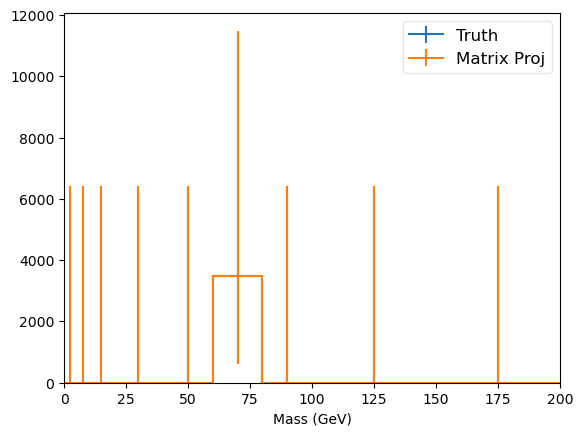

In [20]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_u_gen'].project('ptgen','mgen')[2,hist.rebin(1)]
h2 = out['response_matrix_u'].project('ptgen','mgen')[2,hist.rebin(1)]
h1.plot(label='Truth')
h2.plot(label='Matrix Proj')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.0, 200.0)

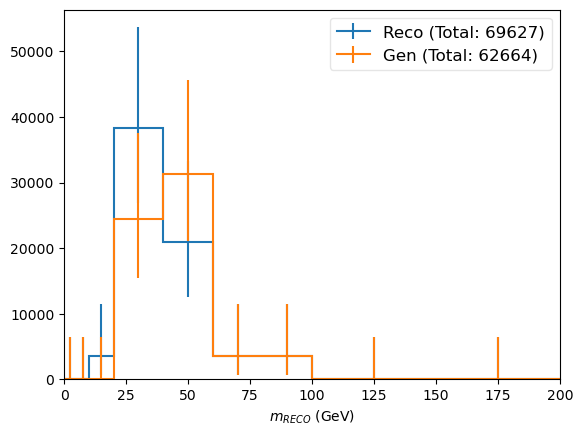

In [21]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_u_reco'].project('ptreco','mreco')[0,hist.rebin(2)]
h2 = out['ptjet_mjet_u_gen'].project('ptgen','mgen')[0,hist.rebin(1)]
h1.plot(label='Reco')
h2.plot(label='Gen')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

/usr/local/lib/python3.10/site-packages/mplhep/utils.py:652: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values(), variances) - self.values())


(0.0, 200.0)

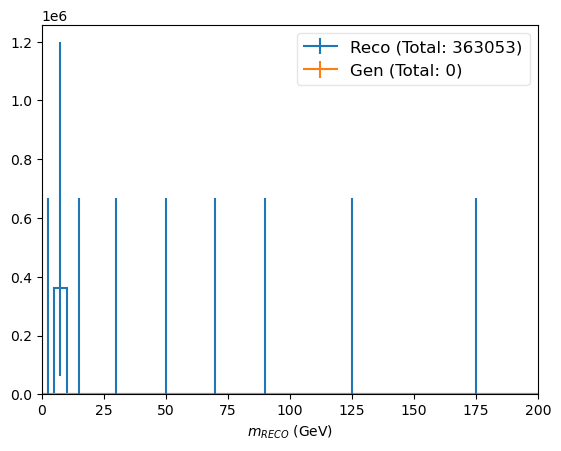

In [41]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_g_reco'].project('mreco')[hist.rebin(2)]
h2 = out['ptjet_mjet_g_gen'].project('mgen')[hist.rebin(1)]
h1.plot(label='Reco')
h2.plot(label='Gen')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

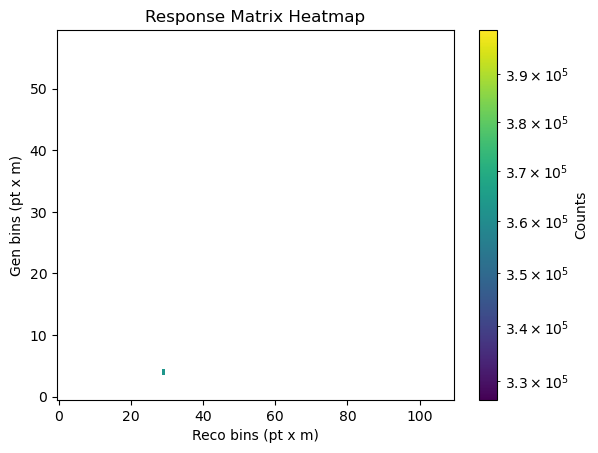

In [42]:
h_resp = out['response_matrix_u'].project('ptgen', 'mgen', 'ptreco', 'mreco')
resp_vals = h_resp.values(flow = True)
resp_vals_2d = resp_vals.reshape(resp_vals.shape[0]*resp_vals.shape[1], resp_vals.shape[2]*resp_vals.shape[3])
plt.imshow(resp_vals_2d, origin='lower', aspect='auto', cmap='viridis', norm = 'log')
plt.colorbar(label='Counts')
plt.xlabel('Reco bins (pt x m)')
plt.ylabel('Gen bins (pt x m)')
plt.title('Response Matrix Heatmap')
plt.show()

In [43]:
resp_vals.sum(axis= (0,1,3))

array([     0.    , 363053.1228,      0.    ,      0.    ,      0.    ])

In [44]:
import pickle
with open("test_output.pkl", "wb") as f:
    pickle.dump(out, f)
print(f"Output written to test_output.pkl with size {os.path.getsize('test_output.pkl')/1e3:.1f} KB")

Output written to test_output.pkl with size 219.2 KB
